# **Word embedding usando Word2Vec + redes neuronales recurrentes**

En esta libreta, se recoge un modelo basando en word embedding usando Word2Vec y redes neuronales recurrentes para la clasificación de noticias como reales o falsas. Este modelo se ha construido y probado usando el dataset "fake and real news" de kaggle ([enlace a los datos](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)).

Este modelo es el segundo de tres que se probarán sobre este set de datos, ya que en este tipo de problemas tanto el proceso de preparación de los datos como el modelo de clasificación pueden influir en el resultado.

Esta libreta se ha ejecutado desde Google Colaboratory.

## Indice

* [1. Carga y limpieza de datos](#section1)
* [2. Comprobar si el dataframe está equilibrado](#section2)
* [3. Preparación de datos](#section3)
* [4. Word embedding usando Word2Vec](#section4)
* [5. Redes neuronales recurrentes](#section5)
  * [5.1. Preparar entradas a la red neuronal](#section5.1)
  * [5.2. Arquitectura y configuración de la red neuronal](#section5.2)
  * [5.3. Crear sets de datos de entrenamiento, de validación y de test](#section5.3)
  * [5.4. Entrenamiento de la red neuronal](#section5.4)
  * [5.5. Resultados de la red neuronal](#section5.5)
  * [5.6. Ajuste de hiperparámetros](#section5.6)
* [6. Conclusiones](#section6)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

sns.set_theme(style="white")

A continuación, se fijan los números aleatorios siguiendo las instrucciones recogidas en el siguiente [enlace](https://datascience.stackexchange.com/questions/112252/reproduce-keras-training-results-in-jupyter-notebook) para garanizar que los resultados de la red neuronal sean reproducibles al volver a ejecutar la libreta.

In [ ]:
# valor de la semilla a utilizar
seed_value = 0

# se fija la variable de sistema 'PYTHONHASHSEED'
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

# se fija la semilla usada en el generador de números pseudo-aleatorios de python
import random
random.seed(seed_value)

# se fija la semilla usada en el generador de números pseudo-aleatorios de numpy
np.random.seed(seed_value)

# se fija la semilla usada en el generador de números pseudo-aleatorios de tensorflow
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

<a id="section1"></a>

## 1. Carga y limpieza de datos

El proceso de carga y limpieza de datos es similar al que se expuso en libretas previas. Primero, se cargan las noticias reales en el dataframe ***df_true*** y las noticias falsas en el dataframe ***df_fake*** que, en este caso, se encuentran almacenadas en la carpeta "News" de mi unidad de Google Drive. Después, se eliminan los duplicados de ambos dataframe y las filas del datafarme ***df_fake*** para las que la fecha no está bien informada (en este punto, la fecha no es relevante, pero se ha observado que para esas filas el título y el cuerpo de la noticia no están bien informados tampoco al recoger una URL y no un texto como tal). Luego, se añade la columna "class" a cada uno de estos dataframes (class=0 indicará que la noticia es real y class=1 que la noticia es falsa). A continuación, se concatenan los dataframes formando ***df_news***, se crea una columna adicional en este dataframe ("full_text") con la concatenación del título y del cuerpo de la noticia y se seleccionan sólo las columnas con las que se va a trabajar en los siguientes apartados ("full_text" y "class"). Por último, se desordenan los datos ya que originalmente aparecían ordenados por la columna "class" y se muestra su estructura y las primeras filas del dataframe. El resultado es un dataframe con 44679 noticias formado por dos columnas: "full_text" (donde se recoge el texto relativo al título y al cuerpo de la noticia) y "class" (class=0 si la noticia es real y class=1 si la noticia es falsa).

In [ ]:
# conexión con Google Drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# contenido de la carpeta de Google Drive donde tengo los datos de entrada
%ls "/content/drive/My Drive/News"

Fake.csv  True.csv


In [ ]:
# se cargan las noticias reales y falsas en dataframes
df_true = pd.read_csv('/content/drive/My Drive/News/True.csv', sep=',', parse_dates=['date'])
df_fake = pd.read_csv('/content/drive/My Drive/News/Fake.csv', sep=',', parse_dates=['date'])

In [ ]:
# se eliminan los duplicados
df_true = df_true.drop_duplicates(keep='first')
df_fake = df_fake.drop_duplicates(keep='first')

In [ ]:
# se eliminan las filas para las que la fecha no aparece bien informada
df_fake['date'] = pd.to_datetime(df_fake['date'], errors='coerce')
df_fake = df_fake.dropna(subset=['date'])

In [ ]:
# se añade una columna adicional a cada dataframe indicando la clase de la noticia
df_true['class'] = 0
df_fake['class'] = 1

In [ ]:
# se concatenan los dataframes
df_news = pd.concat([df_true, df_fake])

In [ ]:
# se crea una columna adicional con el texto que se va a utilizar en próximos apartados (título + cuerpo de la noticia)
df_news['full_text'] = df_news['title'] + ' ' + df_news['text']

In [ ]:
# se filtran las columnas relevantes del dataframe
df_news = df_news[['full_text', 'class']]

In [ ]:
# se desordenan los datos
df_news = df_news.sample(frac=1, random_state=0)

In [ ]:
# se muestra la información del dataframe y sus primeras filas
df_news.info()
df_news.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44679 entries, 7627 to 2743
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  44679 non-null  object
 1   class      44679 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


,full_text,class
7627,Scooby Doo’s ‘Mystery Machine’ Involved In Cr...,1
4826,Trump Campaign Manager And CEO Outed As Membe...,1
14254,SHERIFF CLARKE HAMMERS HOME THE TRUTH: Protest...,1
9286,WEEK #13 of NFL HELL CONTINUES: “Lots of Empty...,1
14226,So Much For Brussels Terror Victims…Let’s Play...,1


<a id="section2"></a>

# 2. Comprobar si el dataframe está equilibrado

Se crea un gráfico de sectores para analizar de forma visual si el dataframe ***df_news*** está equilibrado según la clase. En vista de este gráfico, se comprueba que los datos están bastante balanceados, lo que es importante a la hora de entrenar la red neuronal.

In [ ]:
dict_class_as_text = {0: 'Reales', 1: 'Falsas'}

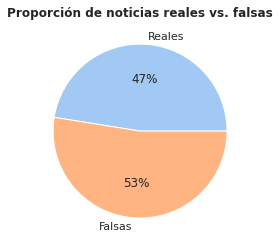

In [ ]:
df_news_pie = df_news.groupby(by='class')['full_text'].count().reset_index().rename(columns={'full_text': 'num_news'})
df_news_pie['class'] = df_news_pie['class'].apply(lambda x: dict_class_as_text[x])

plt.figure(figsize = (4, 4))

colors = sns.color_palette('pastel')[0:2]

plt.pie(df_news_pie['num_news'], labels = df_news_pie['class'], colors = colors, autopct='%.0f%%')
plt.title("Proporción de noticias reales vs. falsas", {"fontsize": 12, 'fontweight': 'bold'});
plt.show()

<a id="section3"></a>

# 3. Preparación de datos

Se crea una función que elimina las etiquetas HTML de un texto.

In [ ]:
def removeHTML(text):
    # se sustituyen las etiquetas HTML por un espacio
    text = re.sub('<[^>]*>', ' ', text)

    return text

Se crea una función para limpiar un texto, convirtiendo el texto en minúsculas y borrando aquellos caracteres que no son alfabéticos.

In [ ]:
def clean(text):
    # se transforma todo el texto a minúsculas
    text = text.lower()
    # se sustituyen los grupos de caracteres que no contienen letras o números (como, por ejemplo, signos de puntuación o símbolos de moneda) por un espacio
    text = re.sub('[\W]+', ' ', text)
    # se sustituyen los números (como, por ejemplo, años o cantidades económicas) que aparezcan en el texto por un espacio
    text = re.sub('[\d]+', ' ', text)

    return text

Se almacenan las stopwords (o palabras sin significado como artículos, preposiciones, etc.) en inglés para luego utilizarlas. Además, se crea el lemitizador que tranformará una forma flexionada de una palabra (por ejemplo, una forma en plural o en femenino) en la forma (o lema) que se acepta como representante de esa palabra por convenio.

In [ ]:
# Este primer bloque sólo es necesario ejecutarlo la primera vez
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stopwords_en = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Se crear una función para extraer los términos relevantes de un texto. Se ha modificado la salida de esta función respecto a la utilizada en libretas anteriores ya que ahora es preciso que devuelva una lista de palabras según el texto introducido en la entrada.

In [ ]:
def extractTerms(text):
    # se extraen los token del texto
    text = word_tokenize(text)
    # se extrae el listado de palabras que no están incluidas dentro del listado de stopwords
    word_list = [word for word in text if word not in stopwords_en]
    # se realiza el proceso de lematización sobre el listado de palabras anterior
    lemmatized_word_list = [lemmatizer.lemmatize(word) for word in word_list]

    # se devuelve la lista de palabras anterior
    return lemmatized_word_list

Se procesa la columna "full_text" del dataframe ***df_news*** usando las funciones "removeHTML", "clean" y "extractTerms" y se muestra un ejemplo del resultado.

In [ ]:
df_news['full_text'] = df_news['full_text'].apply(removeHTML)
df_news['full_text'] = df_news['full_text'].apply(clean)
df_news['full_text'] = df_news['full_text'].apply(extractTerms)
df_news.head()

,full_text,class
7627,"[scooby, doo, mystery, machine, involved, craz...",1
4826,"[trump, campaign, manager, ceo, outed, member,...",1
14254,"[sheriff, clarke, hammer, home, truth, protest...",1
9286,"[week, nfl, hell, continues, lot, empty, seat,...",1
14226,"[much, brussels, terror, victim, let, play, ba...",1


Se crean dos arrays con los que se trabajará después (X -> listado de palabras relevantes por noticia e y -> clase de la noticia) y se muestra un ejemplo de su contenido.

In [ ]:
X = df_news['full_text'].values
print("X - ejemplo contenido: ", X[0:2])

y = df_news['class'].values
print("y - ejemplo contenido: ", y[0:2])

X - ejemplo contenido:  [list(['scooby', 'doo', 'mystery', 'machine', 'involved', 'crazy', 'mph', 'getaway', 'file', 'one', 'wtf', 'woman', 'driving', 'van', 'painted', 'match', 'mystery', 'machine', 'van', 'scooby', 'doo', 'cartoon', 'decided', 'solving', 'crime', 'square', 'led', 'police', 'high', 'speed', 'chase', 'california', 'florida', 'would', 'normally', 'expect', 'imagine', 'bystander', 'saw', 'well', 'done', 'replica', 'even', 'funky', 'hubcap', 'flash', 'cop', 'car', 'pursuit', 'wondered', 'someone', 'making', 'movie', 'redding', 'com', 'report', 'shasta', 'county', 'probation', 'department', 'official', 'contacted', 'redding', 'police', 'department', 'subject', 'violating', 'probation', 'sometime', 'around', 'p', 'sunday', 'woman', 'identified', 'sharon', 'kay', 'turman', 'redding', 'sgt', 'ron', 'icely', 'said', 'news', 'release', 'officer', 'spotted', 'turman', 'chrysler', 'town', 'country', 'minivan', 'california', 'shasta', 'street', 'fled', 'south', 'vehicle', 'officer

<a id="section4"></a>

## 4. Word embedding usando Word2Vec

Word Embedding hace referencia a un conjunto de métodos de aprendizaje que se utilizan para representar las palabras de un texto mediante vectores de números reales. A diferencia del método TF-IDF estudiado en el modelo anterior, los métodos de word embedding capturan el contexto y la similitud semántica y sintáctica (género, sinónimos, etc.) de cada palabra.

Word2Vec es una técnica de word embedding publicada en 2013 por el equipo de Google, que, al igual que otras técnicas de esta familia, representa cada una de las palabra de una lista por un vector de números reales. Estos vectores serán escogidos de forma que la similitud coseno que existe entre ellos indique el grado de similitud entre las palabras que representan. Word2Vec utiliza una red neuronal de tres capas (una capa de entrada, una capa oculta y una capa de salida) para aprender asociaciones entre palabras a partir del corpus de textos introducido como entrada. Una vez entrenado el modelo, puede establecer relaciones entre palabras similares o sugerir palabras para completar una frase.

A continuación, se entrena un modelo de Word2Vec para el conjunto de datos X. Como parámetros del modelo, se ha utilizado:
* ***size=100***. Este parámetro representa el tamaño del vector de números reales que se utilizará para presentar cada palabra. El tamaño no conviene que sea pequeño para que no haya pérdida de información en la representación de las palabras, pero tampoco debe ser muy grande. Según las fuentes consultadas, un tamaño de vector comprendido entre 100 y 150 está bien. En este caso, se ha elegido un tamaño igual a 100 que corresponde con el valor definido por defecto.
* ***window=5***. Este parámetro representa la distancia máxima entre la palabra actual y su vecina más lejana a la derecha o a la izquierda que se utiliza  para establecer el contexto de una palabra. Esta ventana debe ser pequeña pero tampoco debe ser muy pequeña para no perder información sobre el contexto. En este caso, se ha elegido un tamaño de ventana igual a 5 que corresponde con el valor definido por defecto.
* ***min_count=1***. Este parámetro representa la frecuencia mínima de aparición de una palabra para que se tenga en cuenta en el modelo. Las palabras que presenten una frecuencia de aparición menor a la definida por este parámetro serán excluidas. En este caso, se ha elegido el valor definido por defecto para este parámetro, que tiene en cuenta todas las palabras.
* ***seed=0***, ***workers=1*** y ***hashfxn=hash*** son parámetros que se han definido para tener un comportamiento determinista del modelo y que así, sus resultados sean deterministas al volver a ejecutar la libreta.

In [ ]:
from gensim.models import Word2Vec

def hash(astring):
  return ord(astring[0])

embedding_dim = 100

w2v_model = Word2Vec(sentences=X, size=embedding_dim, window=5, min_count=1, seed=0, workers=1, hashfxn=hash)

El tamaño del vocabulario es de 107723 palabras, algo superior respecto al generado por el modelo TF-IDF en la libreta anterior (107695).

In [ ]:
words = w2v_model.wv.vocab
print("El tamaño del vocabulario es: ", len(words))

El tamaño del vocabulario es:  107723


A modo de ejemplo, a continuación, se muestra el vector de 100 componentes asociado a la palabra "scooby" que forma parte del vocabulario. Vectores de este tipo son los que se utilizarán en el próximo apartado de este documento para codificar las palabras de cada noticia como paso previo a su entrada en la red neuronal encargada de clasificar una noticia como real o falsa.

In [ ]:
w2v_model.wv['scooby']

array([ 0.00466799, -0.13161781,  0.06978514, -0.22667295,  0.0576136 ,
       -0.15555511, -0.21237715, -0.17097034,  0.28473476,  0.07144456,
        0.18556063,  0.05440595,  0.02866097,  0.1861393 ,  0.09366973,
        0.1513106 , -0.02876553, -0.05675207, -0.02325764,  0.13997743,
       -0.07556184, -0.18055001,  0.22150429,  0.29070306, -0.02134297,
       -0.13957314,  0.01278521,  0.26331332,  0.10316925, -0.25670385,
        0.02120364, -0.29915264,  0.17552797, -0.19314581, -0.36588606,
       -0.01858755,  0.1250369 , -0.08759111, -0.0489186 ,  0.04570169,
        0.20520177, -0.12263737, -0.14515738, -0.0396862 , -0.15998219,
       -0.07953788, -0.04145449, -0.15579143,  0.01086103, -0.10853732,
        0.03416409,  0.17259005,  0.18253289, -0.10305066,  0.19400218,
        0.04124624, -0.07966882, -0.09115265, -0.18722497,  0.03361996,
        0.08610447, -0.21055384,  0.2332039 ,  0.29355022,  0.27073643,
       -0.08450761, -0.12907031, -0.1161337 , -0.32665658,  0.01

Usando el siguiente código, se pueden identificar las "n" palabras (en este caso, 5) que presentan una mayor similitud con "scooby".

In [ ]:
w2v_model.wv.most_similar('scooby', topn=5)

[('cristal', 0.7571771740913391),
 ('cough', 0.7412261962890625),
 ('barked', 0.7380431294441223),
 ('raunchy', 0.7360036373138428),
 ('handler', 0.7321243286132812)]

Usando el siguiente código, se puede identificar el grado de similitud que existe ente dos palabras concretas. En este caso, entre "scooby" y "cristal".

In [ ]:
w2v_model.wv.similarity('scooby', 'cristal')

0.7571771

Representación de la palabra 'trump'.

In [ ]:
w2v_model.wv['trump']

array([ 2.5036428 , -2.9802752 ,  0.535264  ,  1.3121579 , -4.1501226 ,
        1.0186361 ,  1.1016191 ,  1.3260312 , -0.08244933,  1.6075246 ,
        1.1536111 , -0.7150105 ,  0.268136  , -0.75718117, -1.8002802 ,
        4.1952243 , -1.934085  , -0.9675007 ,  1.9592189 ,  0.11853532,
        3.4372363 ,  0.96368057,  2.1334007 , -3.1786513 , -2.4516928 ,
       -1.1436738 ,  0.6675963 ,  0.3931846 ,  0.8608744 , -1.5455681 ,
       -0.40785655,  0.92343813,  0.7115498 ,  1.6974049 , -0.27514106,
       -2.2658727 , -0.02216071, -0.59847754, -1.7370702 ,  1.5937502 ,
        1.9621929 ,  1.5597136 , -0.07156368, -2.1043935 , -0.76374584,
        0.09578301,  0.8109328 , -1.8307376 ,  0.27438924,  0.51236445,
        1.3571575 , -1.2219253 , -1.338565  , -2.8338914 ,  1.0138575 ,
        0.7350535 , -1.6104354 , -2.481284  ,  0.2760091 , -3.0262065 ,
       -1.9371175 ,  1.5987066 , -0.8004591 , -0.2582277 , -1.1587739 ,
        1.6372106 ,  0.91436005, -0.7564616 ,  1.4155587 ,  0.13

Palabras que están más relacionadas con la palabra 'trump'.

In [ ]:
w2v_model.wv.most_similar('trump', topn=5)

[('elect', 0.693642258644104),
 ('conway', 0.5263651013374329),
 ('obama', 0.49584853649139404),
 ('bush', 0.4907580614089966),
 ('actually', 0.4876587390899658)]

Relación entre las palabras 'trump' y 'football'.

In [ ]:
w2v_model.wv.similarity('trump', 'football')

0.0076821134

<a id="section5"></a>

## 5. Redes neuronales recurrentes

En este apartado, se va a construir y a probar una red neuronal recurrente para clasificar las noticias como reales o falsas.

<a id="section5.1"></a>

## 5.1. Preparar entradas a la red neuronal

El array X (donde se recoge el listado de palabras que presenta cada noticia) será preprocesado antes de utilizarlo como dato de entrada de la red neuronal usando la clase "Tokenizer", que permite vectorizar un corpus de textos convirtiendo cada texto en una secuencia de números enteros.



Para hacer esto, primero, se actualiza el vocabulario interno de la clase en base al listado de noticias. Como resultado de este paso, se tiene un diccionario con 107723 entradas (tamaño del vocabulario visto en apartados previos) donde a cada palabra se le asigna un número entero único mayor o igual que uno (el cero está reservado para el padding), presentando un menor número aquellas palabras que aparecen con mayor frecuencia en el conjunto de textos. Según el exportado de ejemplo que se indica a continuación, "trump" es la palabra más frecuente para el conjunto de noticias analizadas al tener asociado el número 1 y, por ejemplo, la palabra "president" es menos frecuente que "state" al tener la primera un número asignado mayor que la segunda.

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index

print('Tamaño del vocabulario: ', len(word_index))

print('Primeras palabras del vocabulario:')
for word, index in word_index.items():
    print(f'{word} -> {index}')
    if index == 10:
        break

Tamaño del vocabulario:  107723
Primeras palabras del vocabulario:
trump -> 1
said -> 2
u -> 3
state -> 4
president -> 5
would -> 6
people -> 7
year -> 8
republican -> 9
one -> 10


A continuación, se transforma la lista de palabras relativa a cada noticia en una lista de números enteros haciendo uso del diccionario creado anteriormente. Por ejemplo, en el siguiente ejemplo, se puede ver como la décima palabra de la primera noticia es "one" que equivale a "10" según el diccionario anterior.

In [ ]:
print('Ejemplo de texto antes de trasformación: ', X[0][:10])

X = tokenizer.texts_to_sequences(X)

print('Ejemplo de texto después de trasformación: ', X[0][:10])

Ejemplo de texto antes de trasformación:  ['scooby', 'doo', 'mystery', 'machine', 'involved', 'crazy', 'mph', 'getaway', 'file', 'one']
Ejemplo de texto después de trasformación:  [21020, 39980, 5587, 2239, 634, 1874, 10182, 13031, 1273, 10]


Una vez hecho esto, se debe procesar X para trabajar con noticias de la misma longitud de tal forma que para las noticias con una longitud superior a la elegida, se eliminen las palabras que sobran y para las noticias con una longitud inferior a la elegida, se realice un padding completando con ceros las posiciones faltantes.

La longitud de las noticias con las que estamos trabajando varía entre 3 palabras (para noticias muy cortas donde sólo existe un título y no texto como, por ejemplo, "LIVE FEED: INAUGURATION 2017!" publicada el 20 de enero de 2017) y 4989 palabras (para noticias más largas). Volviendo al inicio y analizando los datos de partida de nuevo, se han identificado 627 noticias que sólo poseen título y no texto (código utilizado para identificar texto definido como un único espacio después de concatenar las noticias reales y falsas: mask = (df_news['text'].str.len() == 1), df_news_wo_text = df_news.loc[mask], df_news_wo_text.info()).

In [ ]:
list_len = [len(i) for i in X]
print('Número de palabras para la noticia con menos palabras: ', min(list_len))
print('Número de palabras para la noticia con más palabras: ', max(list_len))

Número de palabras para la noticia con menos palabras:  3
Número de palabras para la noticia con más palabras:  4989


La siguiente gráfica muestra la distribución del número de palabras por noticia y en ella se puede ver que el número de noticias con más de 1000 palabras (relativas al título y al cuerpo de la noticia) es escaso (menos del 0.68%), por lo que éste será el factor de corte que se considerará en adelante.

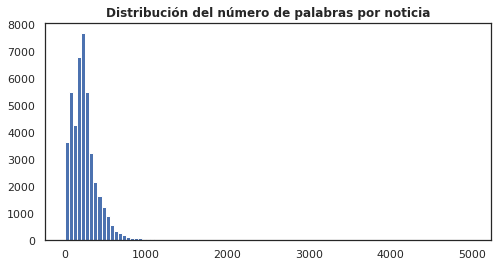

In [ ]:
plt.figure(figsize = (8, 4))

colors = sns.color_palette('pastel')[0:2]

plt.hist([len(x) for x in X], bins=100)
plt.title("Distribución del número de palabras por noticia", {"fontsize": 12, 'fontweight': 'bold'});
plt.show()

In [ ]:
# número de palabras por noticia
num_words_per_news = np.array([len(x) for x in X])

# número de noticias con más de 1000 palabras
new_more_1000_words = len(num_words_per_news[num_words_per_news  > 1000])

# porcentaje de noticias con más de 1000 palabras
per_new_more_1000_words = new_more_1000_words/len(X) * 100
print('Porcentaje de noticias con más de 1000 palabras: ', per_new_more_1000_words)

Porcentaje de noticias con más de 1000 palabras:  0.6781709527966159


Una vez identificado el factor de corte, se aplica la función "pad_sequences" para homogeneizar la longitud de las noticias con las que se va a trabajar. De esta forma, se trabajará con 44679 noticias todas ellas de longitd 1000 palabras. En el ejemplo que se muestra a continuación, puede verse como la primera noticia se ha completado con ceros para alcanzar esta longitud.

In [ ]:
from keras.utils import pad_sequences

print('Número de noticias: ', len(X))
print('Número de palabras de la primera noticia antes de aplicar pad_sequence: ', len(X[0]))

maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

print('Número de palabras de la primera noticia después de aplicar pad_sequence: ', len(X[0]))

Número de noticias:  44679
Número de palabras de la primera noticia antes de aplicar pad_sequence:  233
Número de palabras de la primera noticia después de aplicar pad_sequence:  1000


Actualizamos el tamaño del vocabulario introduciendo un término más (el correspondiente a las palabras ficticias introducidas mediante el padding para completar la secuencia).

In [ ]:
vocab_size = len(word_index) + 1
print('Tamaño del vocabulario: ', vocab_size)

Tamaño del vocabulario:  107724


Creamos una función para unificar los vectores calculados mediante el Word2Vec en una matriz de pesos y guardamos su resultado.

In [ ]:
def get_weight_matrix(model, vocab, emb_dim):
  # el tamaño del vocabulario corresponde con el tamaño del diccionario vocab más 1, debido al término de extra introducido con el padding
  vocab_size = len(vocab) + 1

  # se crea una matriz de ceros con n filas y m columnas (n=longitud del vocabulario y m=tamaño del vector utilizado para represetar cada palabra)
  weight_matrix = np.zeros((vocab_size, emb_dim))

  # se completa la matriz con los pesos proporcionados por el modelo model para cada palabra
  for word, index in vocab.items():
    try:
      weight_matrix[index] = model.wv[word]
    except:
      continue

  # se devuelve la matriz de pesos
  return weight_matrix

# se ejecuta la función anterior para el modelo "w2v_model"" definido anteriormente, el diccionario "word_index" y el tamaño de vector "embedding_dim"
embedding_vectors = get_weight_matrix(w2v_model, word_index, embedding_dim)

La matriz de pesos es de tamaño 107724 (tamaño del vocabulario) por 100 (dimensión del vector utilizado para representar cada palabra).

In [ ]:
embedding_vectors.shape

(107724, 100)

Los pesos relativos a la primera fila de esta matriz son cero ya que corresponden con los pesos relativos a la palabra extra creada durante el padding.

In [ ]:
embedding_vectors[0][:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Como puede verse a continuación, los pesos relativos a la segunda fila de esta matriz corresponden con los pesos de la palabra "trump" (primera palabra del vocabulario) calculados mediante el modelo Word2Vec.

In [ ]:
w2v_model.wv['trump']

array([ 2.5036428 , -2.9802752 ,  0.535264  ,  1.3121579 , -4.1501226 ,
        1.0186361 ,  1.1016191 ,  1.3260312 , -0.08244933,  1.6075246 ,
        1.1536111 , -0.7150105 ,  0.268136  , -0.75718117, -1.8002802 ,
        4.1952243 , -1.934085  , -0.9675007 ,  1.9592189 ,  0.11853532,
        3.4372363 ,  0.96368057,  2.1334007 , -3.1786513 , -2.4516928 ,
       -1.1436738 ,  0.6675963 ,  0.3931846 ,  0.8608744 , -1.5455681 ,
       -0.40785655,  0.92343813,  0.7115498 ,  1.6974049 , -0.27514106,
       -2.2658727 , -0.02216071, -0.59847754, -1.7370702 ,  1.5937502 ,
        1.9621929 ,  1.5597136 , -0.07156368, -2.1043935 , -0.76374584,
        0.09578301,  0.8109328 , -1.8307376 ,  0.27438924,  0.51236445,
        1.3571575 , -1.2219253 , -1.338565  , -2.8338914 ,  1.0138575 ,
        0.7350535 , -1.6104354 , -2.481284  ,  0.2760091 , -3.0262065 ,
       -1.9371175 ,  1.5987066 , -0.8004591 , -0.2582277 , -1.1587739 ,
        1.6372106 ,  0.91436005, -0.7564616 ,  1.4155587 ,  0.13

In [ ]:
embedding_vectors[1][:]

array([ 2.5036428 , -2.98027515,  0.53526402,  1.31215787, -4.15012264,
        1.01863611,  1.10161912,  1.32603121, -0.08244933,  1.60752463,
        1.15361106, -0.71501052,  0.26813599, -0.75718117, -1.80028021,
        4.19522429, -1.93408501, -0.96750069,  1.95921886,  0.11853532,
        3.43723631,  0.96368057,  2.13340068, -3.17865133, -2.45169282,
       -1.14367378,  0.66759628,  0.3931846 ,  0.86087441, -1.54556811,
       -0.40785655,  0.92343813,  0.71154982,  1.69740486, -0.27514106,
       -2.26587272, -0.02216071, -0.59847754, -1.7370702 ,  1.59375024,
        1.96219289,  1.5597136 , -0.07156368, -2.10439348, -0.76374584,
        0.09578301,  0.81093282, -1.83073759,  0.27438924,  0.51236445,
        1.35715747, -1.22192526, -1.33856499, -2.83389139,  1.01385748,
        0.73505348, -1.61043537, -2.4812839 ,  0.27600911, -3.02620649,
       -1.93711746,  1.5987066 , -0.80045909, -0.25822771, -1.1587739 ,
        1.63721061,  0.91436005, -0.75646162,  1.4155587 ,  0.13

<a id="section5.2"></a>

## 5.2. Arquitectura y configuración de la red neuronal

Se trabajará con una red neuronal recurrente con una arquitectura similar a la que vimos en una de las clases de teoría para un problema de análisis de sentimientos realizado sobre un conjunto de documentos. Esta red estará compuesta por:
* Una capa de embedding, que trabaja con entradas con un número fijo de palabras (input_length) incluidas dentro de un vocabulario de un tamaño determinado (vocab_size). Esta capa permite traducir la representación entera de cada palabra a vectores de un determinado tamaño (embedding_dim) con los que posteriormente trabajará la red. En este caso, estos vectores (embedding_vectors) vienen dados por el modelo Word2Vec aplicado previamente por lo que los parámetros de esta capa no necesitan ser calculados durante el proceso de entrenamiento de la red (trainable=False).
* Una capa LSTM (Long-Short Term Memory), que, a diferencia de las redes neuronales recurrentes básicas que sólo presentan memoria a corto plazo, presenta memoria tanto a corto como a largo plazo, lo que la hace especialmente útil cuando se trabaja con secuencias largas de palabras. En este caso, vamos a probar con una capa compuesta por 128 unidades o celdas LTSM (valor que se ha utilizado en dos de los trabajos consultados: [enlace1](https://www.kaggle.com/code/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy) y [enlace2](https://www.kaggle.com/code/omermo/fake-news-detection-word2vec-lstm-99-8-accuracy/notebook)), por lo que, según [enlace3](https://www.kaggle.com/code/kmkarakaya/lstm-understanding-the-number-of-parameters), habrá que entrenar 4 × ((x + h) × h + h) parámetros (donde x corresponde con la dimensión del vector que representa cada palabra, que es 100, y h con el número de las unidades o celdas LSTM, que es 128). No se establecerá dropout en esta capa con el objetivo de comenzar con una red lo más sencilla posible.
* Una capa de fully connected compuesta por una neurona y con una función de activación sigmoidal que transforma los datos de entrada a esa capa en valores comprendidos entre 0 y 1 a la salida. Este tipo de función de activación tiene interés para problemas de clasificación binaria como el que nos ocupa en esta libreta. En este caso, el número de parámetros a entrenar corresponde con los pesos de las conexiones que existen entre las 128 unidades de la capa LSTM y la única neurona de esta capa más el bias.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(vocab_size, output_dim=embedding_dim, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         10772400  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 10,889,777
Trainable params: 117,377
Non-trainable params: 10,772,400
_________________________________________________________________


Para el entrenamiento, se utilizará la siguiente configuración:
* Función de pérdida: "binary_crossentropy", que calcula la pérdida de entropía cruzada entre etiquetas verdaderas y etiquetas predichas y es la función a minimizar.
* Optimizador: "Adam". Es el más complejo de los optimizadores vistos en clase, pero por lo general funciona bien. La ventaja de este optimizador es que combina learning rate adaptativo y memoria.
* Learning_rate: 0.0001. Suele estar comprendido entre 0.1 y 0.0001. En este caso, se ha escogido un valor igual a 0.0001 con el objetivo de que la optimización de los parámetros de la red neuronal se realice lentamente. Luego habrá que comprobar que si la función de pérdidas reduce bien su valor durante el proceso de aprendizaje o varía muy poco al haber elegido un valor demasiado pequeño.
* Métrica: "accuracy" o precisión.
* Epochs: 6, que corresponde con el número de veces o ciclos que se ejecutarán los algoritmos de forwardpropagation y backpropagation durante el entrenamiento de la red.
* Tamaño de batch: 128, que corresponde con el máximo número de noticias que se procesarán por iteración dentro de cada ciclo o epoch. Dividir el problema cuando hay muchos datos que procesar puede llegar a evitar la necesidad de trabajar con GPUs.

In [ ]:
from keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

epochs = 6
batch_size = 128


<a id="section5.3"></a>

## 5.3. Crear sets de datos de entrenamiento, de validación y de test

Los datos originales (X, y -> 100% de los datos originales) se van a separar en dos conjuntos: datos que utilizaremos para entranar y validar el modelo (X_train_val, y_train_val -> 75% de los datos originales) y datos que utilizaremos para calcular su rendimiento (X_test, y_test -> 25% de los datos originales).

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("La matriz X para los datos de entrenamiento y validación tiene la siguiente dimensión: ", X_train_val.shape)
print("La variable objetivo para los datos de entrenamiento y validación tiene la siguiente dimensión: ", y_train_val.shape)

print("La matriz X para los datos de test tiene la siguiente dimensión: ", X_test.shape)
print("La variable objetivo para los datos de test tiene la siguiente dimensión: ", y_test.shape)

La matriz X para los datos de entrenamiento y validación tiene la siguiente dimensión:  (33509, 1000)
La variable objetivo para los datos de entrenamiento y validación tiene la siguiente dimensión:  (33509,)
La matriz X para los datos de test tiene la siguiente dimensión:  (11170, 1000)
La variable objetivo para los datos de test tiene la siguiente dimensión:  (11170,)


<a id="section5.4"></a>

## 5.4. Entrenamiento de la red neuronal

Se entrena la red con el 75% de los datos de entrenamiento y de validación (X_train_val, y_train_val) y el 25% restante se utiliza para validar sus resultados.

Según puede verse a continuación, el proceso de entrenamiento ha tardado algo más de una hora. En él, se han ejecutado 6 epochs y 197 iteraciones de tamaño 128 noticias o menos (en el caso de la iteración 197) por epoch para procesar las 25131 entradas que corresponden con los datos de entrenamiento.

In [ ]:
history = model.fit(X_train_val, y_train_val, batch_size=batch_size, epochs=epochs, validation_split=0.25)

Epoch 1/6
197/197 [==============================] - 739s 4s/step - loss: 0.2878 - accuracy: 0.9018 - val_loss: 0.1421 - val_accuracy: 0.9493
Epoch 2/6
197/197 [==============================] - 736s 4s/step - loss: 0.1144 - accuracy: 0.9600 - val_loss: 0.1000 - val_accuracy: 0.9654
Epoch 3/6
197/197 [==============================] - 742s 4s/step - loss: 0.0887 - accuracy: 0.9715 - val_loss: 0.0887 - val_accuracy: 0.9703
Epoch 4/6
197/197 [==============================] - 740s 4s/step - loss: 0.0766 - accuracy: 0.9762 - val_loss: 0.0796 - val_accuracy: 0.9758
Epoch 5/6
197/197 [==============================] - 744s 4s/step - loss: 0.0605 - accuracy: 0.9827 - val_loss: 0.0618 - val_accuracy: 0.9819
Epoch 6/6
197/197 [==============================] - 843s 4s/step - loss: 0.0474 - accuracy: 0.9864 - val_loss: 0.0405 - val_accuracy: 0.9885


En la siguiente figura, se muestra la evolución de la función de pérdidas y de la precisión a lo largo de las 6 epochs ejecutadas. Tanto en los datos de entrenamiento como en los datos de validación se muestra una reducción de las función de pérdidas y una mejora de la precisión con cada epoch. Parece que no hay problemas de sobreajuste ya que la precisión sigue mejorando en cada epoch para los datos de validación. Sin embargo, las curvas relativas a los datos de entrenamiento y de validación están muy pegadas y esto podría indicar un subajuste que podría solucionarse con la ejecución de más epochs o aumentando la complejidad de la red.

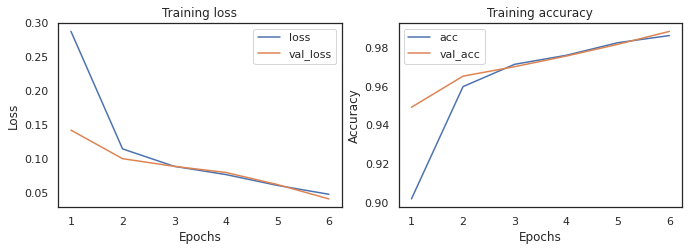

In [ ]:
fig=plt.figure(figsize=(60, 40))

xticks_ini = np.arange(0, epochs, 1).tolist()
xticks_new = np.arange(1, epochs + 1, 1).tolist()

# error
fig.add_subplot(10, 10, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.xticks(xticks_ini, xticks_new)
plt.ylabel('Loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 2)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.xticks(xticks_ini, xticks_new)
plt.ylabel('Accuracy')
plt.legend()

plt.show()

<a id="section5.5"></a>

## 5.5. Resultados de la red neuronal

**Precisión de la red**

Se evalúa la red utilizando los datos de test y se obtiene una precisión muy buena (0.9873769283294678), a pesar de ser algo peor que la obtenida con el modelo TFID + regresión logística con 1000 palabras (0.9949865711727842) (en ambos casos los valores son muy buenos).

Las buenas tasas de acierto de ambos modelos se pueden deber al gran número de palabras consideradas y también, quizás a la falta de balanceo que hay en los datos según la temática y las fechas de publicación. Según se indicaba en el análisis exploratorio inicial de los datos, las noticias reales y falsas no compartían temática y había un pico de noticias reales cargadas en los últimos meses de la serie temporal que se espera que traten sobre un contenido similar.

In [ ]:
model.evaluate(X_test, y_test, batch_size=batch_size)

88/88 [==============================] - 121s 1s/step - loss: 0.0423 - accuracy: 0.9874


[0.042348798364400864, 0.9873769283294678]

**Matriz de confusión**

Sacamos la matriz de confusión y vemos que los resultados de la red neuronal son muy buenos ya que casi todos los datos están en la diagonal.

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test, batch_size=batch_size)
# truncamos valores ya que el resultado de la red son valores comprendidos entre 0 y 1 (asimilables a probabilidades)
y_pred[y_pred>0.5] = 1
y_pred[y_pred<=0.5] = 0

# se obtiene la matriz de confusión
# las filas corresponden con las clases reales y las columnas con las predicciones
cm = confusion_matrix(y_test, y_pred)
print('Matriz de confusión: \n\n', cm, '\n')

88/88 [==============================] - 122s 1s/step
Matriz de confusión: 

 [[5247   95]
 [  46 5782]] 



**Proporción real de noticias falsas y proporción de noticias falsas etiquetadas**

El error entre la proporción real de noticias falsas y la proporción de noticias falsas etiquetadas (falsos positivos y verdaderos positivos) es mínimo pero algo superior que el obtenido para el modelo TFID + regresión logística con 1000 palabras, ya que la proporción (en tanto por uno) de noticias falsas etiquetas ha pasado de 0.5212 a 0.5261.

In [ ]:
prop_real = np.sum(y_test)/len(y_test)
prop_etiquetadas = (cm[0,1]+cm[1,1])/len(y_test)

print('Proporción real de noticias falsas: %.4f'% prop_real)
print('Proporción de de noticias falsas etiquetadas: %.4f'% prop_etiquetadas)

Proporción real de noticias falsas: 0.5218
Proporción de de noticias falsas etiquetadas: 0.5261


<a id="section5.6"></a>

## 5.6. Ajuste de hiperparámetros

Existen varios hiperparámetros que se pueden ajustar para una red neuronal: número de capas, número de nodos por capa, optimizador, etc. En este caso, sólo vamos a probar cómo cambian los resultados del problema si trabajamos con un learning rate algo mayor pasando de utilizar 0.0001 a utilizar 0.001.

En primer lugar, creamos una nueva red similar a la inicial.

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(vocab_size, output_dim=embedding_dim, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model_2.add(LSTM(units=128))
model_2.add(Dense(units=1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         10772400  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10,889,777
Trainable params: 117,377
Non-trainable params: 10,772,400
_________________________________________________________________


Creamos un nuevo optimizador con el nuevo learning rate.

In [ ]:
opt_2 = Adam(learning_rate=0.001)

model_2.compile(optimizer=opt_2, loss='binary_crossentropy', metrics=['accuracy'])

Entrenamos la nueva red de forma similar a como lo hicimos con la red inicial.

In [ ]:
history_2 = model_2.fit(X_train_val, y_train_val, batch_size=batch_size, epochs=epochs, validation_split=0.25)

Epoch 1/6
197/197 [==============================] - 756s 4s/step - loss: 0.1424 - accuracy: 0.9504 - val_loss: 0.0990 - val_accuracy: 0.9693
Epoch 2/6
197/197 [==============================] - 770s 4s/step - loss: 0.0818 - accuracy: 0.9731 - val_loss: 0.0790 - val_accuracy: 0.9742
Epoch 3/6
197/197 [==============================] - 736s 4s/step - loss: 0.0455 - accuracy: 0.9868 - val_loss: 0.0413 - val_accuracy: 0.9878
Epoch 4/6
197/197 [==============================] - 734s 4s/step - loss: 0.0434 - accuracy: 0.9865 - val_loss: 0.0341 - val_accuracy: 0.9900
Epoch 5/6
197/197 [==============================] - 736s 4s/step - loss: 0.0223 - accuracy: 0.9934 - val_loss: 0.0277 - val_accuracy: 0.9943
Epoch 6/6
197/197 [==============================] - 741s 4s/step - loss: 0.0136 - accuracy: 0.9968 - val_loss: 0.0146 - val_accuracy: 0.9963


Ahora, la función de pérdidas alcanza valores inferiores a los obtenidos con la red inicial tanto en entrenamiento como en validación y la precisión también es mayor a pesar de que no haya habido mejora en todas las epoch analizadas (veáse la epoch 4). Al igual que se comentó anteriormente, las curvas relativas a los datos de entrenamiento y de validación están muy pegadas por lo que quizás podríamos probar a entrenar la red durante alguna epoch más para ver su evolución, pero, en cuanlquier caso, los resultados obtenidos son muy buenos.

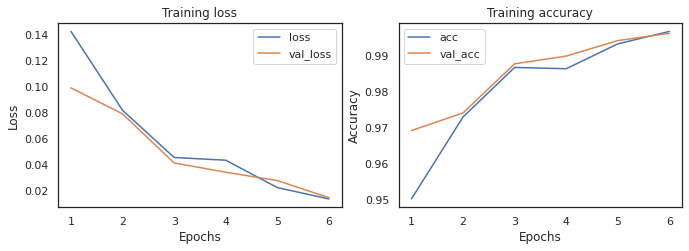

In [ ]:
fig=plt.figure(figsize=(60, 40))

xticks_ini = np.arange(0, epochs, 1).tolist()
xticks_new = np.arange(1, epochs + 1, 1).tolist()

# error
fig.add_subplot(10, 10, 1)
plt.plot(history_2.history['loss'], label='loss')
plt.plot(history_2.history['val_loss'], label='val_loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.xticks(xticks_ini, xticks_new)
plt.ylabel('Loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 2)
plt.plot(history_2.history['accuracy'], label='acc')
plt.plot(history_2.history['val_accuracy'], label='val_acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.xticks(xticks_ini, xticks_new)
plt.ylabel('Accuracy')
plt.legend()

plt.show()

La precisión alcanzada con los datos de test es muy buena (0.9968665838241577) y algo mejor que la obtenida con el modelo TFID + regresión logística con 1000 palabras (0.9949865711727842) y con la red neuronal inicial (0.9873769283294678).

In [ ]:
model_2.evaluate(X_test, y_test, batch_size=batch_size)

88/88 [==============================] - 114s 1s/step - loss: 0.0123 - accuracy: 0.9969


[0.012346373870968819, 0.9968665838241577]

A partir de los siguientes cálculos, se comprueba que el error entre la proporción real de noticias falsas y la proporción de noticias falsas etiquetadas (falsos positivos y verdaderos positivos) es mínimo y algo menor que el obtenido con el modelo TFID + regresión logística y con la red neuronal inicial, ya que la proporción (en tanto por uno) de noticias falsas etiquetas se ha visto reducida. Por tanto, podríamos dar por buenos estos resultados y trabajar en adelante con el modelo entrenado con el nuevo valor del learning rate (0.001).

In [ ]:
y_pred_2 = model_2.predict(X_test, batch_size=batch_size)
y_pred_2[y_pred_2>0.5] = 1
y_pred_2[y_pred_2<=0.5] = 0

# se obtiene la matriz de confusión
# las filas corresponden con las clases reales y las columnas con las predicciones
cm_2 = confusion_matrix(y_test, y_pred_2)
print('Matriz de confusión: \n\n', cm_2, '\n')

88/88 [==============================] - 114s 1s/step
Matriz de confusión: 

 [[5315   27]
 [   8 5820]] 



In [ ]:
prop_real_2 = np.sum(y_test)/len(y_test)
prop_etiquetadas_2 = (cm_2[0,1]+cm_2[1,1])/len(y_test)

print('Proporción real de noticias falsas: %.4f'% prop_real_2)
print('Proporción de de noticias falsas etiquetadas: %.4f'% prop_etiquetadas_2)

Proporción real de noticias falsas: 0.5218
Proporción de de noticias falsas etiquetadas: 0.5235


<a id="section6"></a>

## 6. Conclusiones

Los buenos resultados del modelo sencillo desmerecen los resultados de modelos más complejos donde se tiene en cuenta el contexto y la memoria a largo y a corto. En caso de tener que elegir uno, elegiría el modelo más sencillo para trabajar en un futuro.

Si se quisiera trabajar algo más sobre el modelo que se analiza en esta libreta, probaría a:
* Trabajar con menos palabras por noticias y con vectores más cortos por palabra para ver si se reducen los tiempos de ejecución sin empeorar demasiado los resultados.
* Ejecutar alguna epoch más sobre la última red neuronal para ver cómo se comporta la función de pérdidas y de la precisión.
* Ejecutar la última red usando una GPU con el objetivo de evaluar las mejoras en los tiempos de ejecución.
* Realizar un ajuste de hiperparámetros más detallado.